In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [5]:
submission_example = pd.read_csv("/content/submission.csv")
test = pd.read_csv("/content/test.csv")
train = pd.read_csv("/content/train.csv")
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train[train['Province_State'].isna()==False]['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,19110.000000,19110.000000,19110.000000
mean,14683.000000,365.535113,13.731763
std,8487.242666,3696.254326,196.223162
min,1.000000,0.000000,0.000000
25%,7333.250000,0.000000,0.000000
50%,14683.000000,0.000000,0.000000
75%,22032.750000,17.000000,0.000000
max,29365.000000,80589.000000,8215.000000


Number of Country_Region:  173
Dates go from day 2020-03-26 to day 2020-01-22 , a total of 65 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


Text(0.5, 0, 'Date')

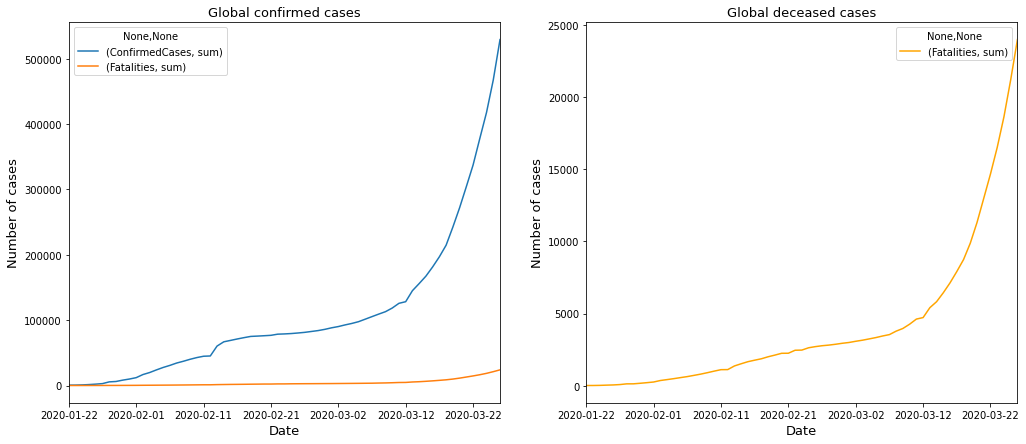

In [6]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

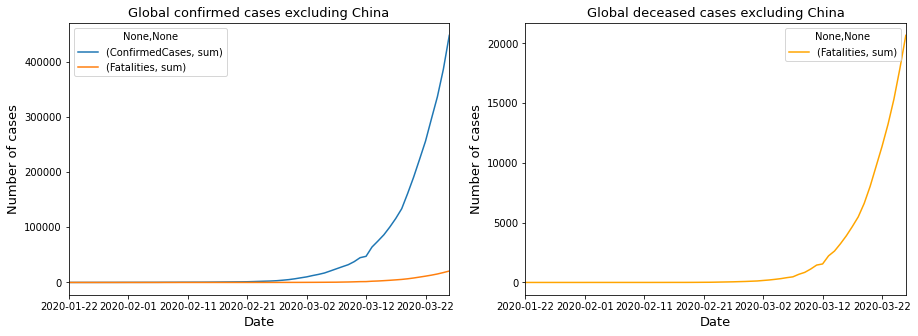

In [7]:
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

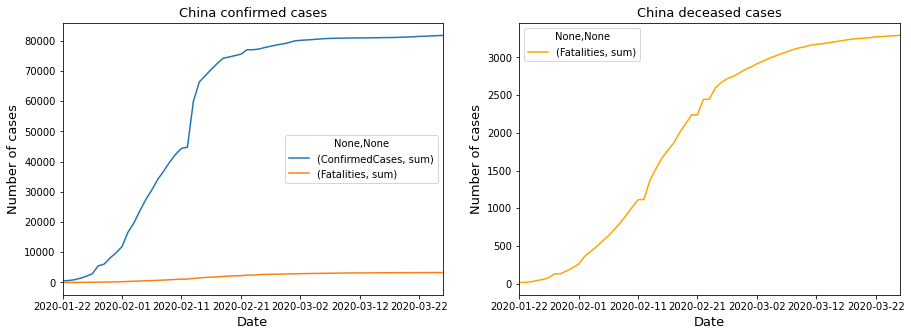

In [8]:
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

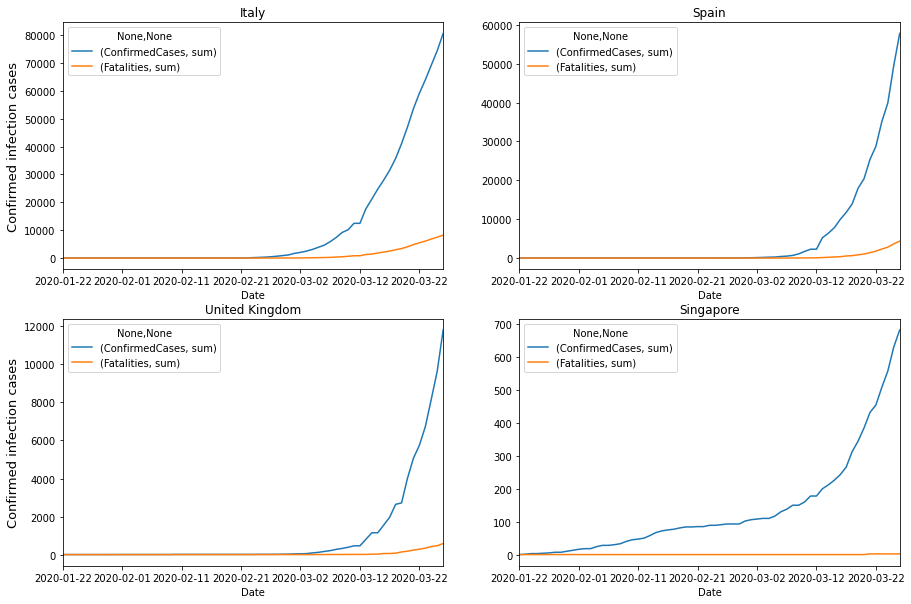

In [10]:
#confirmed_country_Italy = train[train['Country_Region']=='Italy'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[train['Country_Region']=='Italy'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

(0.0, 0.005)

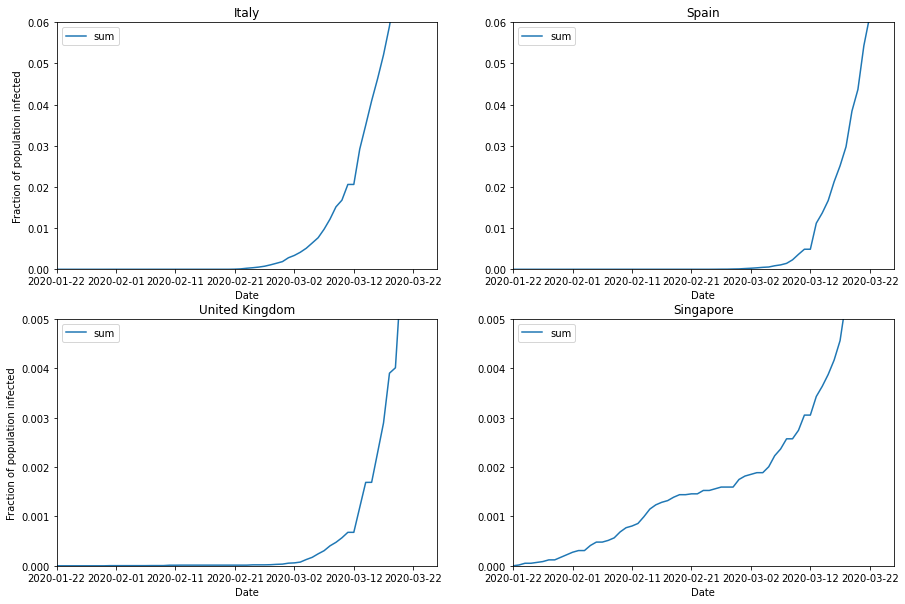

In [11]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.06)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.005)

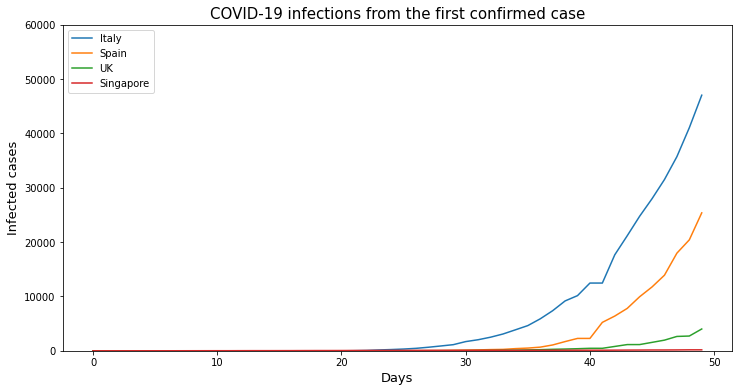

In [13]:
#confirmed_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:50] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:50] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:50] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:50] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.legend(["Italy", "Spain", "UK", "Singapore"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 60000)
plt.show()

In [0]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [0]:
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [0]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

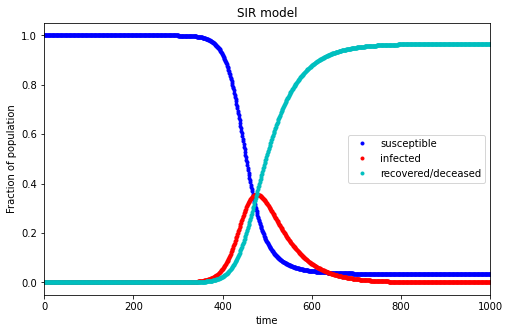

In [19]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

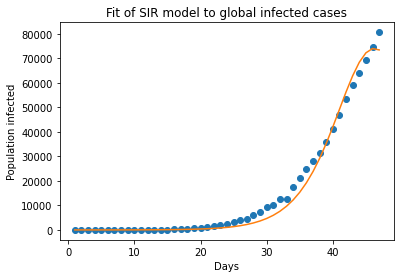

Optimal parameters: beta = 5.189210137070296  and gamma =  4.934625730616789


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

population = float(pop_italy)
country_df = total_date_Italy[9:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases['sum'].values]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [21]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-19', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-19', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-19'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
12637,-1.0,None,Zimbabwe,2020-04-26,0.0,0.0,12638.0,95,26,4,2020
12638,-1.0,None,Zimbabwe,2020-04-27,0.0,0.0,12639.0,96,27,4,2020
12639,-1.0,None,Zimbabwe,2020-04-28,0.0,0.0,12640.0,97,28,4,2020
12640,-1.0,None,Zimbabwe,2020-04-29,0.0,0.0,12641.0,98,29,4,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,-1.0,None,Afghanistan,2020-03-19,0.0,0.0,1.0,57,19,3,2020
43,-1.0,None,Albania,2020-03-19,0.0,0.0,44.0,57,19,3,2020
86,-1.0,None,Algeria,2020-03-19,0.0,0.0,87.0,57,19,3,2020
129,-1.0,None,Andorra,2020-03-19,0.0,0.0,130.0,57,19,3,2020
172,-1.0,None,Angola,2020-03-19,0.0,0.0,173.0,57,19,3,2020
...,...,...,...,...,...,...,...,...,...,...,...
12427,-1.0,None,Uzbekistan,2020-03-19,0.0,0.0,12428.0,57,19,3,2020
12470,-1.0,None,Venezuela,2020-03-19,0.0,0.0,12471.0,57,19,3,2020
12513,-1.0,None,Vietnam,2020-03-19,0.0,0.0,12514.0,57,19,3,2020
12556,-1.0,None,Zambia,2020-03-19,0.0,0.0,12557.0,57,19,3,2020


In [22]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


In [24]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df
ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.21196484565734863


In [25]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
13625,20941.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
13626,20942.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
13627,20943.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
13628,20944.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
13629,20945.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
13630,20946.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
13631,20947.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
13632,20948.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
13633,20949.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
13634,20950.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


In [26]:
world_population = pd.read_csv("/content/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4992,50,100,19,10
231,Falkland Islands,3480,0,12170,19,66
232,Niue,1626,6,260,19,46
233,Tokelau,1357,136,10,19,0


Joined dataset


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,-1.0,None,Zimbabwe,2020-04-26,0.0,0.0,12638.0,95,26,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
29396,-1.0,None,Zimbabwe,2020-04-27,0.0,0.0,12639.0,96,27,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
29397,-1.0,None,Zimbabwe,2020-04-28,0.0,0.0,12640.0,97,28,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
29398,-1.0,None,Zimbabwe,2020-04-29,0.0,0.0,12641.0,98,29,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0


Encoded dataset


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,1.0,79,0,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
1,2.0,79,0,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
2,3.0,79,0,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
3,4.0,79,0,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
4,5.0,79,0,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,-1.0,79,172,2020-04-26,0.0,0.0,12638.0,95,26,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
29396,-1.0,79,172,2020-04-27,0.0,0.0,12639.0,96,27,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
29397,-1.0,79,172,2020-04-28,0.0,0.0,12640.0,97,28,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
29398,-1.0,79,172,2020-04-29,0.0,0.0,12641.0,98,29,4,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0


Text(0, 0.5, 'Log ConfirmedCases')

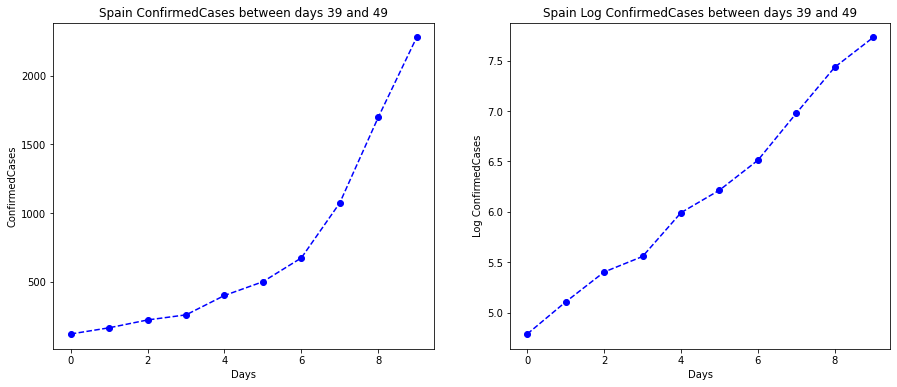

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

In [0]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num', 'Day', 'Month', 'Year']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # Test set
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

In [0]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26']

In [31]:
all_data.loc[all_data['Country_Region']==country_dict['India']][45:65]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
7683,13446.0,79,75,2020-03-07,34.0,0.0,-1.0,45,7,3,2020,31.0,30.0,28.0,5.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096774,0.133333,0.214286,5.800000,5.800000,10.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7684,13447.0,79,75,2020-03-08,39.0,0.0,-1.0,46,8,3,2020,34.0,31.0,30.0,28.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147059,0.258065,0.300000,0.392857,6.800000,6.800000,0.0,0.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7685,13448.0,79,75,2020-03-09,43.0,0.0,-1.0,47,9,3,2020,39.0,34.0,31.0,30.0,28.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102564,0.264706,0.387097,0.433333,0.535714,7.600000,0.0,0.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7686,13449.0,79,75,2020-03-10,56.0,0.0,-1.0,48,10,3,2020,43.0,39.0,34.0,31.0,30.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302326,0.435897,0.647059,0.806452,0.866667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7687,13450.0,79,75,2020-03-11,62.0,1.0,-1.0,49,11,3,2020,56.0,43.0,39.0,34.0,31.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107143,0.441860,0.589744,0.823529,1.000000,1.066667,0.0,0.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7688,13451.0,79,75,2020-03-12,73.0,1.0,-1.0,50,12,3,2020,62.0,56.0,43.0,39.0,34.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,0.177419,0.303571,0.697674,0.871795,1.147059,1.354839,0.0,0.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7689,13452.0,79,75,2020-03-13,82.0,2.0,-1.0,51,13,3,2020,73.0,62.0,56.0,43.0,39.0,34.0,1.0,1.0,0.0,0.0,0.0,0.0,0.123288,0.322581,0.464286,0.906977,1.102564,1.411765,1.0,1.0,0.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7690,13453.0,79,75,2020-03-14,102.0,2.0,-1.0,52,14,3,2020,82.0,73.0,62.0,56.0,43.0,39.0,2.0,1.0,1.0,0.0,0.0,0.0,0.243902,0.397260,0.645161,0.821429,1.372093,1.615385,0.0,1.0,1.0,0.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7691,13454.0,79,75,2020-03-15,113.0,2.0,-1.0,53,15,3,2020,102.0,82.0,73.0,62.0,56.0,43.0,2.0,2.0,1.0,1.0,0.0,0.0,0.107843,0.378049,0.547945,0.822581,1.017857,1.627907,0.0,0.0,1.0,1.0,0.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0
7692,13455.0,79,75,2020-03-16,119.0,2.0,-1.0,54,16,3,2020,113.0,102.0,82.0,73.0,62.0,56.0,2.0,2.0,2.0,1.0,1.0,0.0,0.053097,0.166667,0.451220,0.630137,0.919355,1.125000,0.0,0.0,0.0,1.0,1.0,0.0,1.380004e+09,464.0,2973190.0,28.0,35.0


Text(0.5, 0.98, 'ConfirmedCases predictions based on Log-Lineal Regression for Spain')

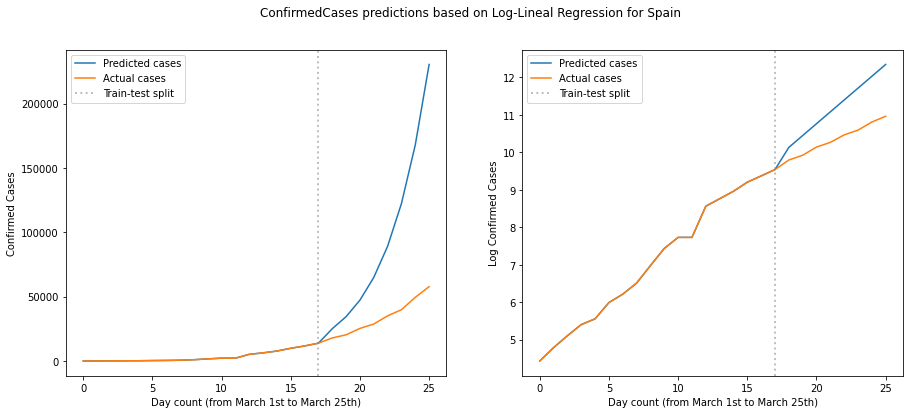

In [32]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
day_start = 39
data_country = data[data['Country_Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 25th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 25th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 25th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Log-Lineal Regression for Italy')

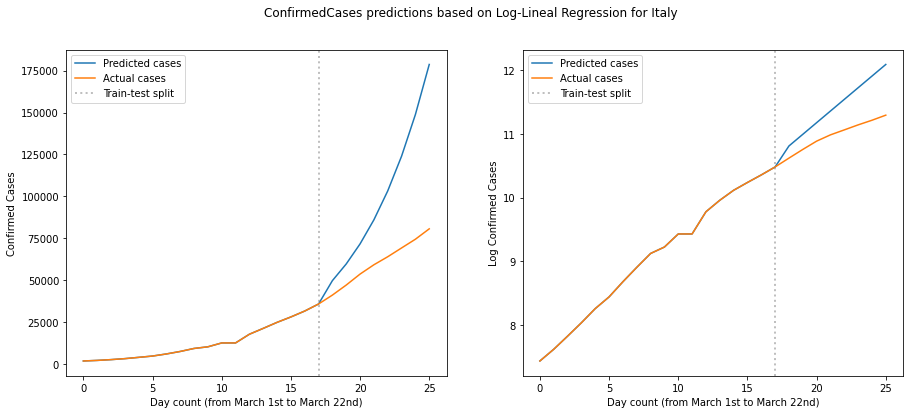

In [33]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
day_start = 39
data_country = data[data['Country_Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Log-Lineal Regression for Germany')

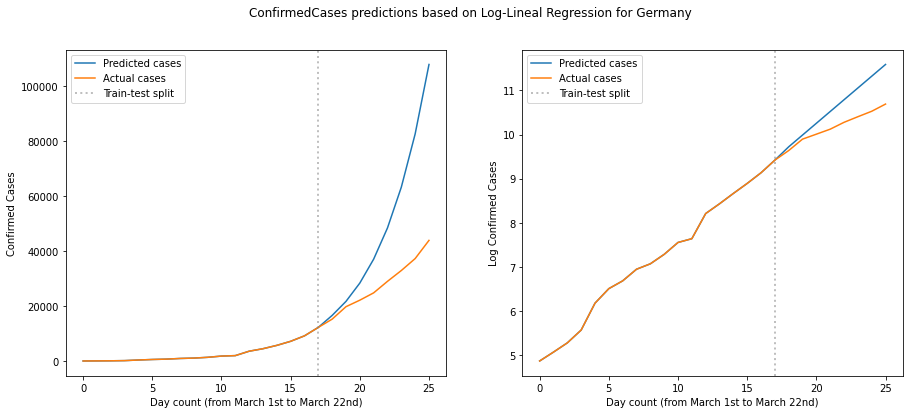

In [34]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
day_start = 39
data_country = data[data['Country_Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])


# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Log-Lineal Regression for Albania')

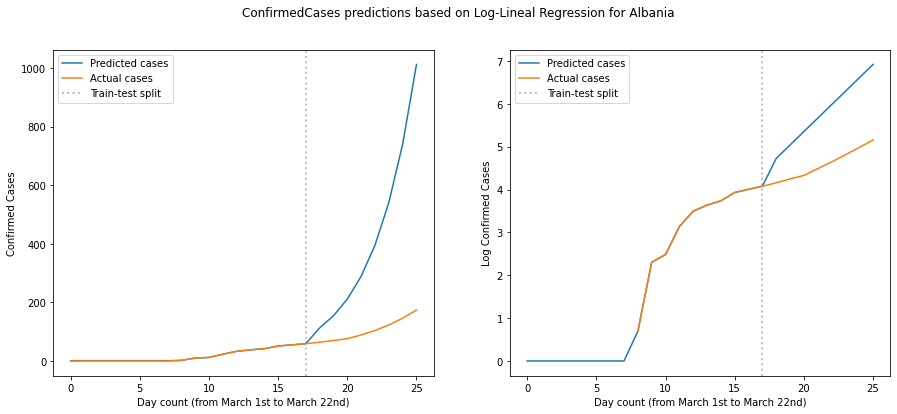

In [35]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
day_start = 39
data_country = data[data['Country_Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Log-Lineal Regression for Andorra')

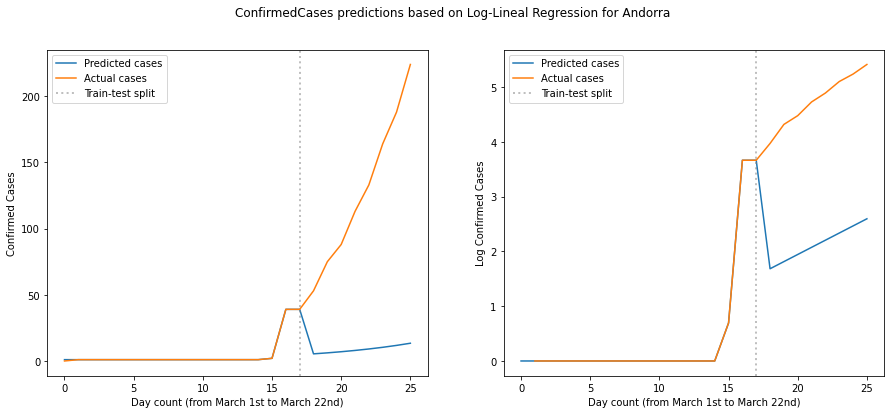

In [36]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
day_start = 39
data_country = data[data['Country_Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

In [37]:
ts = time.time()

day_start = 39
data2 = data.loc[data.Day_num >= day_start]

# Set the dataframe where we will update the predictions
data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
data_pred['Predicted_Fatalities'] = [0]*len(data_pred)
    
print("Currently running Logistic Regression for all countries")

# Main loop for countries
for c in data2['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for p in provinces_list:
            data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        data_c = data2[(data2['Country_Region']==c)]
        X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
        data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.exp(x))
data_pred.replace([np.inf, -np.inf], 0, inplace=True) 

get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression for all countries
Process finished in  7.34  seconds


In [38]:
ts = time.time()

# Set the dataframe where we will update the predictions
data_pred2 = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred2['Predicted_ConfirmedCases'] = [0]*len(data_pred2)
data_pred2['Predicted_Fatalities'] = [0]*len(data_pred2)
how_many_days = test.Date.nunique()
    
print("Currently running Logistic Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred2.loc[((data_pred2['Country_Region']==c) & (data_pred2['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred2.loc[((data_pred2['Country_Region']==c) & (data_pred2['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred2.loc[((data_pred2['Country_Region']==c) & (data_pred2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred2.loc[((data_pred2['Country_Region']==c) & (data_pred2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred2.loc[((data_pred2['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred2.loc[((data_pred2['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred2.loc[(data_pred2['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred2.loc[(data_pred2['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred2[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred2[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.exp(x))
data_pred2.replace([np.inf, -np.inf], 0, inplace=True) 

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression for all countries
Process finished in  3.14  seconds


In [0]:
# New split function, for one forecast day
def split_data_one_day(data, d):
    
    #Train
    x_train = data[data.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = data[data.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.exp(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March 1st)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log(real_data))
    ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March 1st)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.exp(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March 1st)")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log(real_data))
    ax2.axvline(17, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March 1st)")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

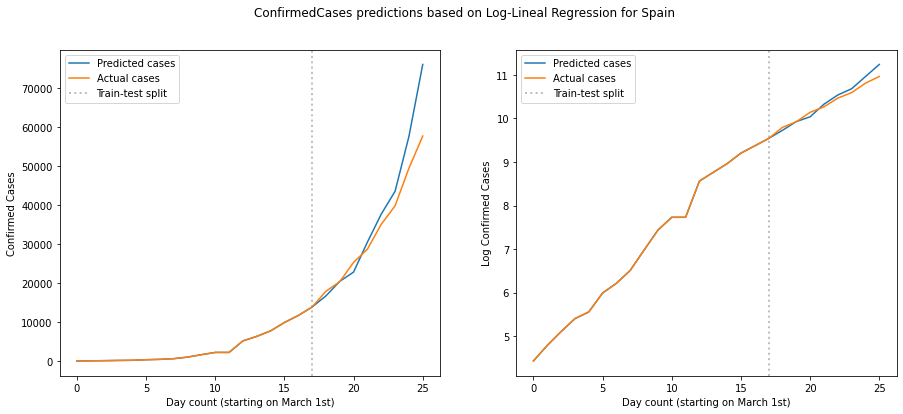

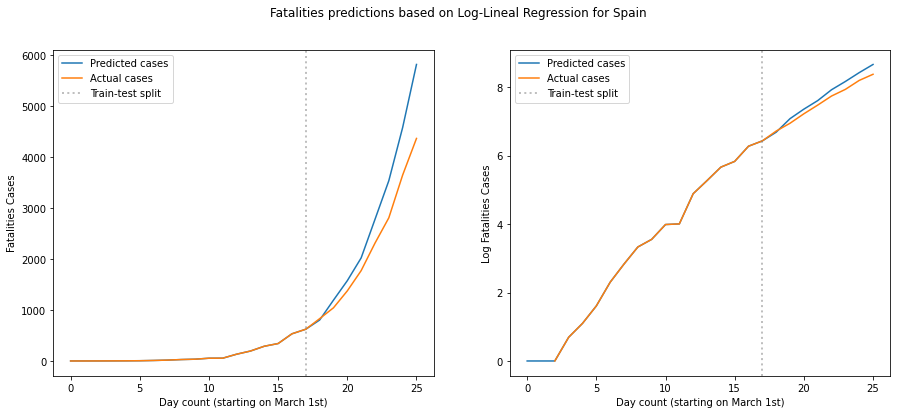

In [40]:
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Run the model for Spain
country_name = 'Spain'
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)



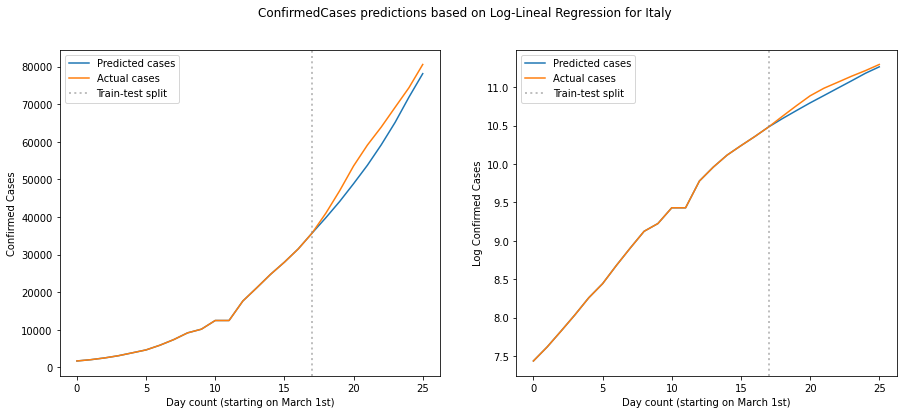

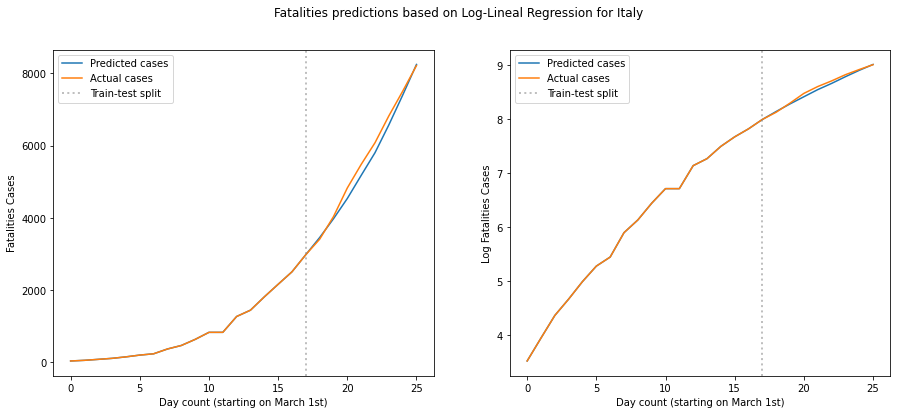

In [41]:
ts = time.time()

# Inputs
country_name = "Italy"
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

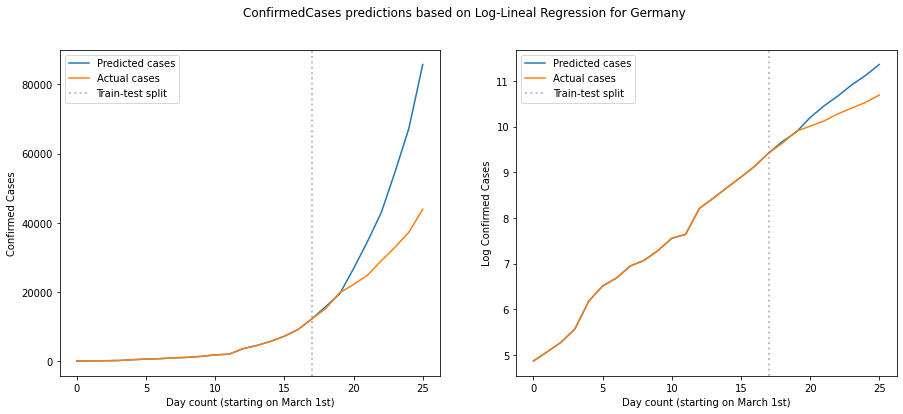

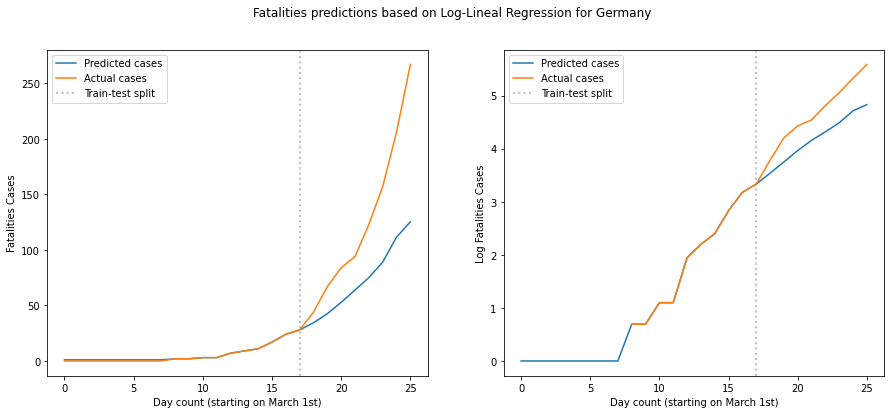

In [42]:
# Inputs
country_name = "Germany"
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

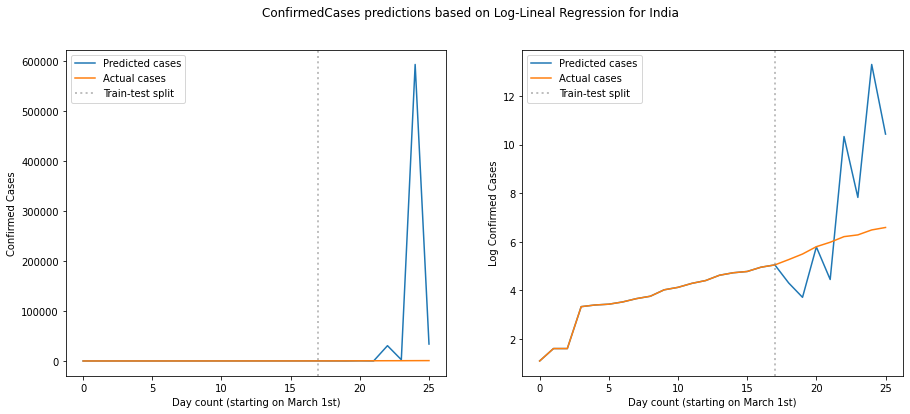

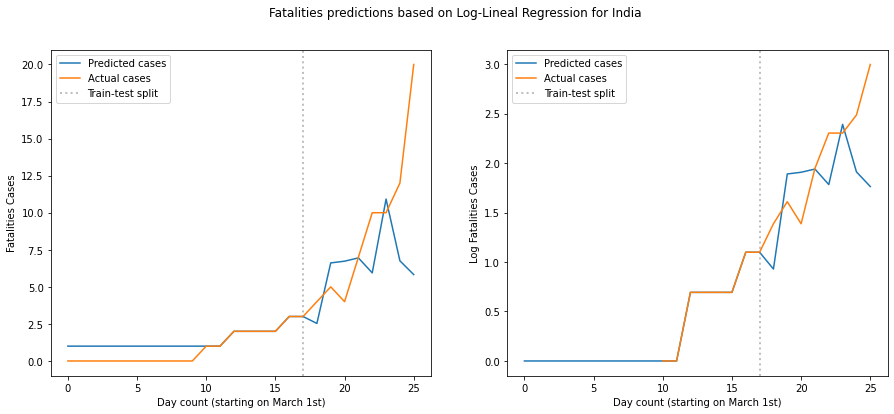

In [43]:
# Inputs
country_name = "India"
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

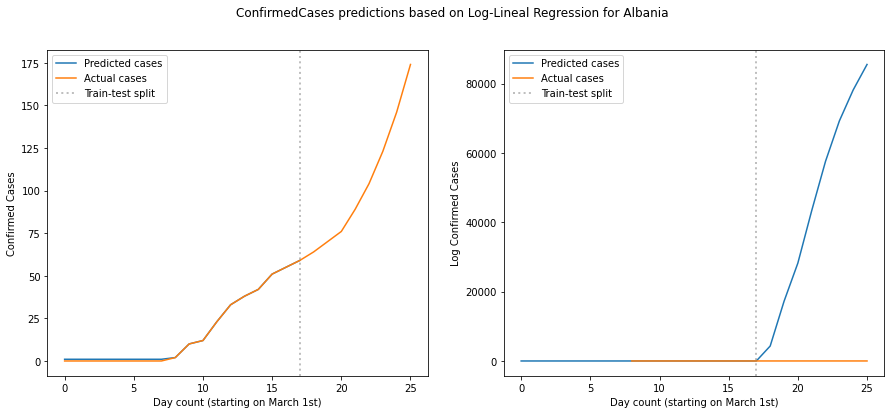

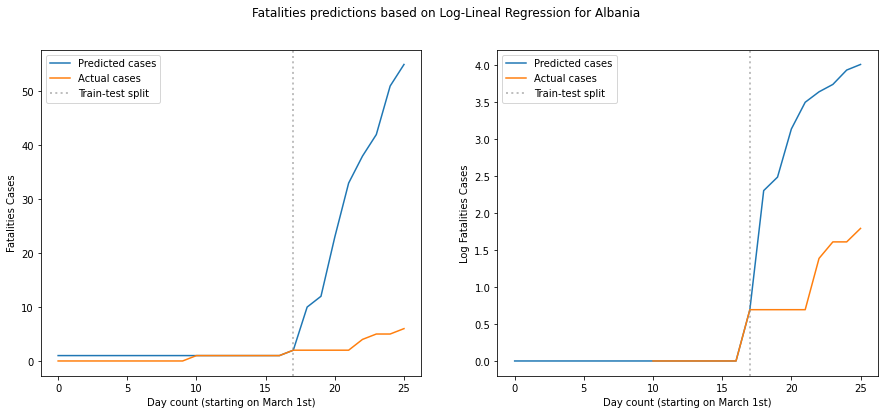

In [44]:
# Inputs
country_name = "Albania"
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

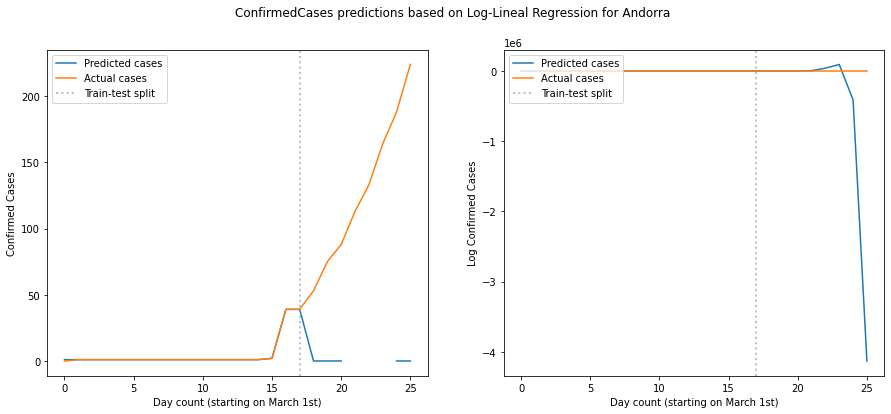

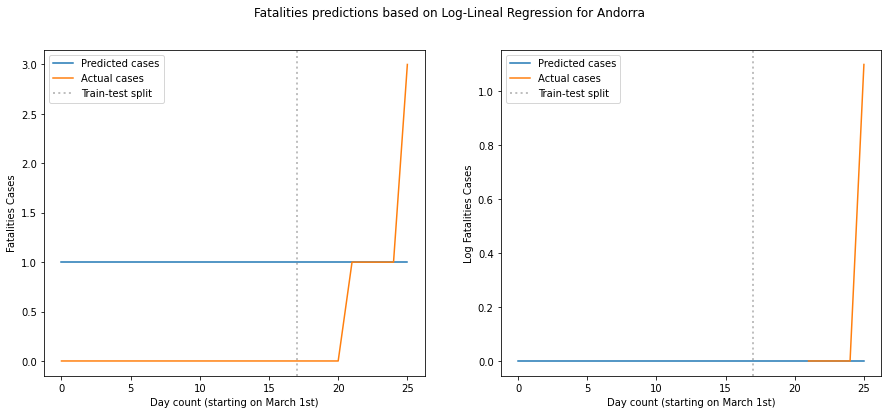

In [45]:
# Inputs
country_name = "Andorra"
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

In [46]:
# Inputs
day_start = 35 
lag_size = 30

results_df = pd.DataFrame()

tp = time.time()

# Main loop for countries
for country_name in train['Country_Region'].unique():

    # List of provinces
    provinces_list = all_data[all_data['Country_Region']==country_name]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
            pred_province = lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict)
            results_df = pd.concat([results_df, pred_province])

    else:
        pred_country = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
        results_df = pd.concat([results_df, pred_country])
        
#get_submission(results_df, 'ConfirmedCases', 'Fatalities')
print("Complete process finished in ", time.time()-tp)

Complete process finished in  198.47586798667908


In [0]:
results_df_2 = results_df.copy()

day_num_test = 57

# Main loop for countries
for country_name in train['Country_Region'].unique():

    # List of provinces
    provinces_list = all_data[all_data['Country_Region']==country_name]['Province_State'].unique()
        
    # Countries with several Province_State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
            tmp_index = results_df_2.index[(results_df_2['Country_Region']==country_dict[country_name]) & 
                           (results_df_2['Province_State']==province_dict[province_name]) & 
                           (results_df_2['Day_num']<day_num_test) & 
                           (results_df_2['ConfirmedCases']!=0)]

            # When there is not enough data
            if len(tmp_index) < 30:
                # ConfirmedCases
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & 
                                  (data_pred['Province_State']==province_dict[province_name]) & 
                                  (data_pred['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log(x))
                
                #Fatalities
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & 
                                  (data_pred['Province_State']==province_dict[province_name]) & 
                                  (data_pred['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log(x))

    # Countries without Province_State
    else:
        tmp_index = results_df_2.index[(results_df_2['Country_Region']==country_dict[country_name]) & 
                           (results_df_2['Day_num']<day_num_test) & 
                           (results_df_2['ConfirmedCases']!=0)]

        # When there is not enough data
        if len(tmp_index) < 30:
            
            #Confirmed Cases
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & 
                            (data_pred['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log(x))
            
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & 
                            (data_pred['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log(x))
            
results_df_2 = results_df_2.loc[results_df_2['Day_num']>=day_num_test]
# get_submission(results_df_2, 'ConfirmedCases', 'Fatalities')